# Testing DeepER

### Import libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append('../')

In [2]:
import time
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
from deeper_model import build_model
from deeper_utils import preprocess_data
from custom_callbacks import Metrics

Using TensorFlow backend.


### Read the dataset

In [3]:
trainData, testData, valData, embeddingMatrix, wordsWithNoEmbeddings = preprocess_data(
    'Fodors_Zagats', baseDir = '..', maxSequenceLength=100)

Printing out words with no embeddings in GloVe

In [4]:
PRINT_RANGE = 30

if len(wordsWithNoEmbeddings) < PRINT_RANGE:
    PRINT_RANGE = len(wordsWithNoEmbeddings)

if PRINT_RANGE > 0:   
    for i in range(PRINT_RANGE):
        print(wordsWithNoEmbeddings[i])

print('...')
print("There are {} words with no embeddings in GloVe".format(len(wordsWithNoEmbeddings)))

petrossian
lespinasse
felidia
eril
bizou
bertolini
lutece
wollensky
hedgerose
matsuhisa
postrio
meatty
buzio
plumpjack
bistango
rondelli
seryna
yolie
manora
hillhurst
nozawa
ciboulette
fringale
menchanko
sanppo
tadich
vivande
oritalia
steuart
kintetsu
...
There are 48 words with no embeddings in GloVe


Print embedding matrix shape

In [5]:
embeddingMatrix.shape

(2075, 300)

In [6]:
leftTableTrainData, rightTableTrainData, trainLabels = trainData
leftTableTestData, rightTableTestData, testLabels = testData
leftTableValData, rightTableValData, valLabels = valData

Print training set size

In [7]:
print(leftTableTrainData.shape)
print(rightTableTrainData.shape)

(567, 100)
(567, 100)


Print test set size

In [8]:
print(leftTableTestData.shape)
print(rightTableTestData.shape)

(189, 100)
(189, 100)


Print validation set size

In [9]:
print(leftTableValData.shape)
print(rightTableValData.shape)

(190, 100)
(190, 100)


### Build the DeepER model 

In [10]:
model = build_model(embeddingMatrix, lstmUnits=75, denseUnits=[16, 8], lstm_dropout=0.1, mask_zero=True, maxSequenceLength=100)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     622500      input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________

### Plot DeepER architecture

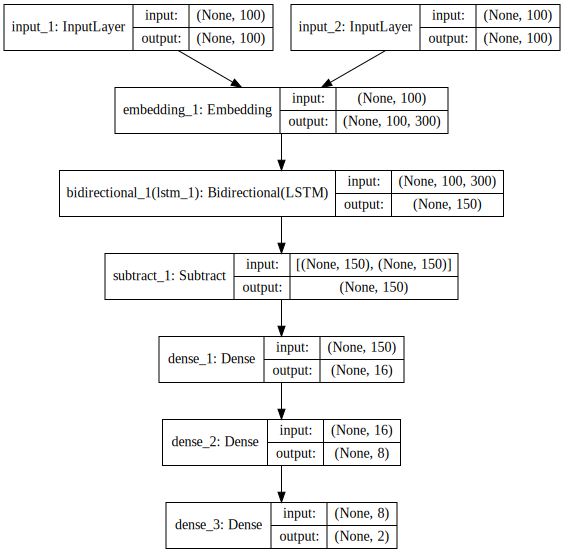

In [11]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Training

In [42]:
start_time = time.time()

metricsHistory = Metrics()
history = model.fit([leftTableTrainData,
           rightTableTrainData],
          trainLabels,
          batch_size=16,
          epochs=20,
          callbacks=[metricsHistory],
          validation_data=([leftTableValData,
                            rightTableValData],
                           valLabels))

elapsed_time = time.time() - start_time
t = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('Elapsed time (learning):', t)

Train on 567 samples, validate on 190 samples
Epoch 1/20
567/567 [==============================] - 7s 12ms/step - loss: 0.0743 - acc: 0.9912 - val_loss: 0.1576 - val_acc: 0.9316
val_f1:0.7234042553191491	val_precision: 0.68	val_recall: 0.7727272727272727
Epoch 2/20
567/567 [==============================] - 7s 12ms/step - loss: 0.0721 - acc: 0.9929 - val_loss: 0.1533 - val_acc: 0.9368
val_f1:0.7391304347826088	val_precision: 0.7083333333333334	val_recall: 0.7727272727272727
Epoch 3/20
567/567 [==============================] - 7s 12ms/step - loss: 0.0701 - acc: 0.9965 - val_loss: 0.1511 - val_acc: 0.9316
val_f1:0.7234042553191491	val_precision: 0.68	val_recall: 0.7727272727272727
Epoch 4/20
567/567 [==============================] - 7s 12ms/step - loss: 0.0691 - acc: 0.9947 - val_loss: 0.1512 - val_acc: 0.9368
val_f1:0.7500000000000001	val_precision: 0.6923076923076923	val_recall: 0.8181818181818182
Epoch 5/20
567/567 [==============================] - 9s 16ms/step - loss: 0.0671 - ac

### Plot loss

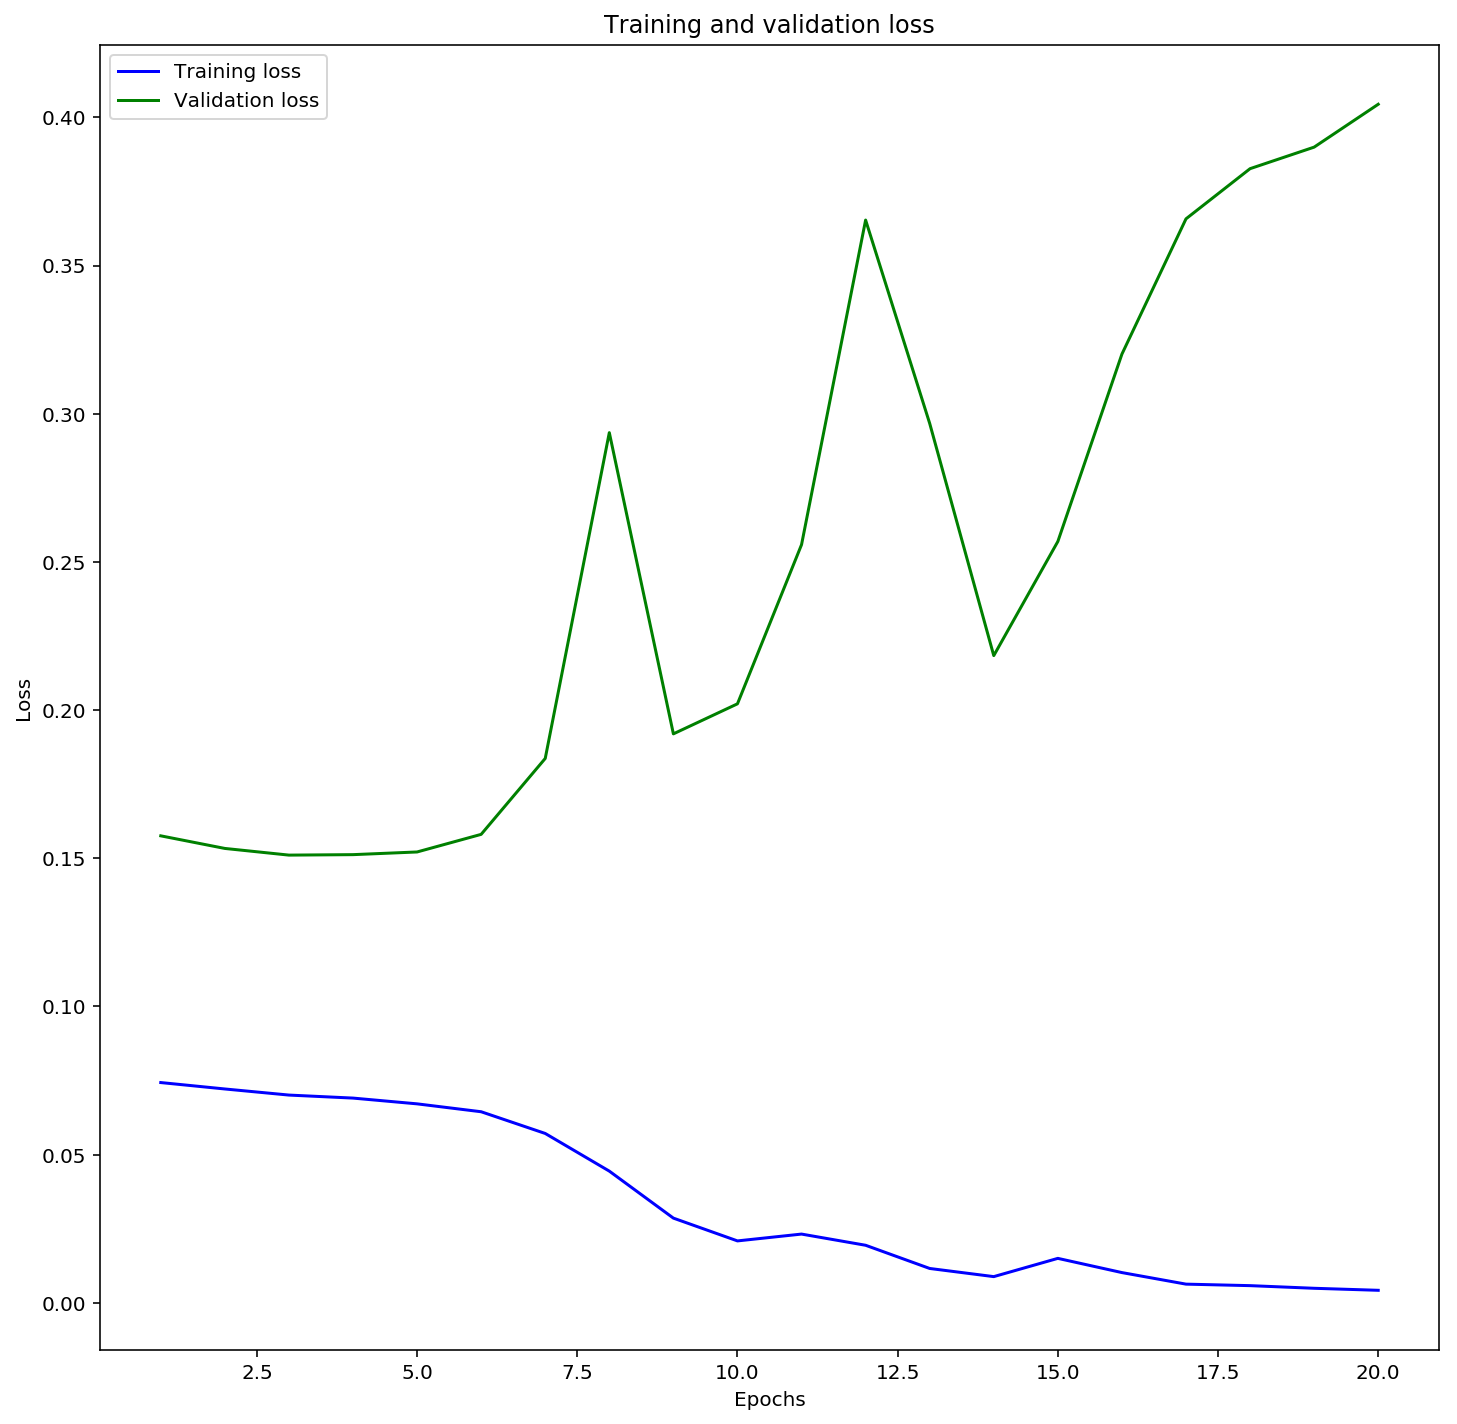

In [43]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,12))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Plot accuracy

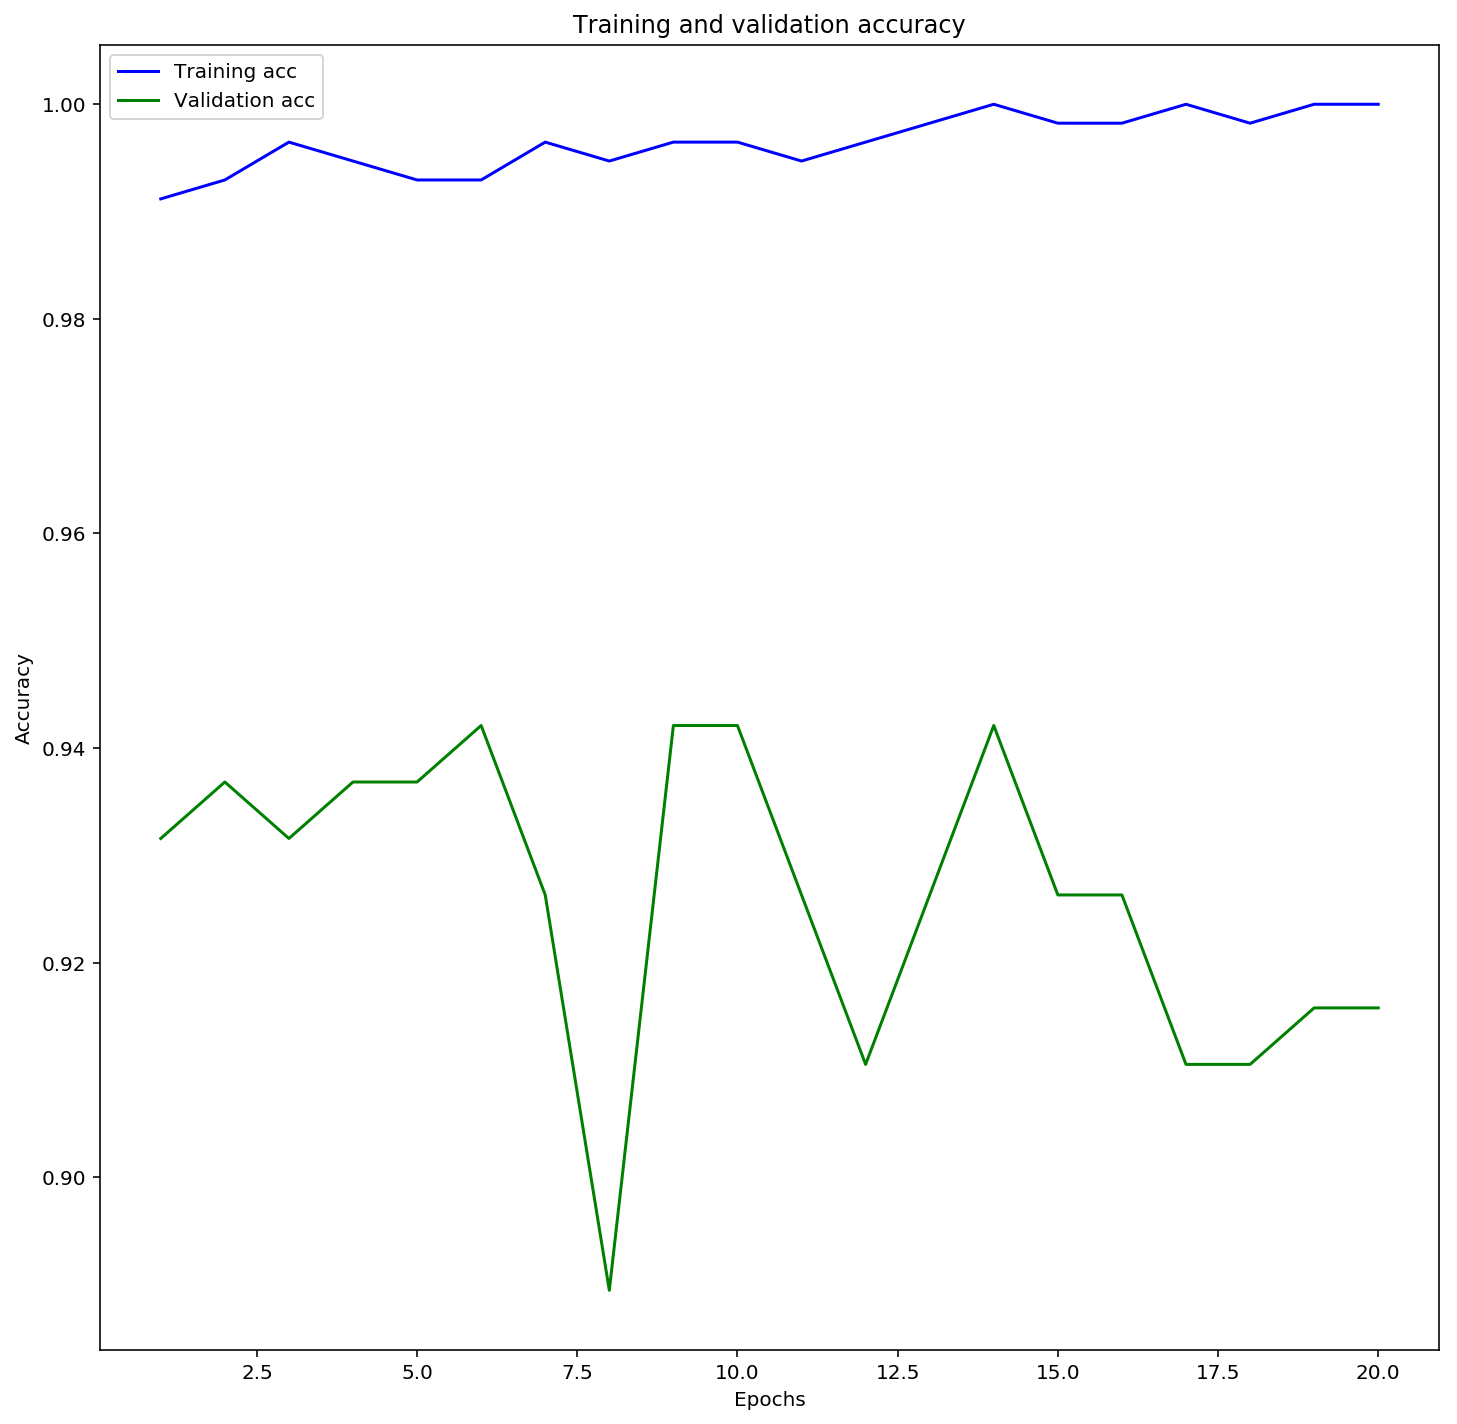

In [44]:
plt.figure(figsize=(12,12))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Plot precision (for matching records)

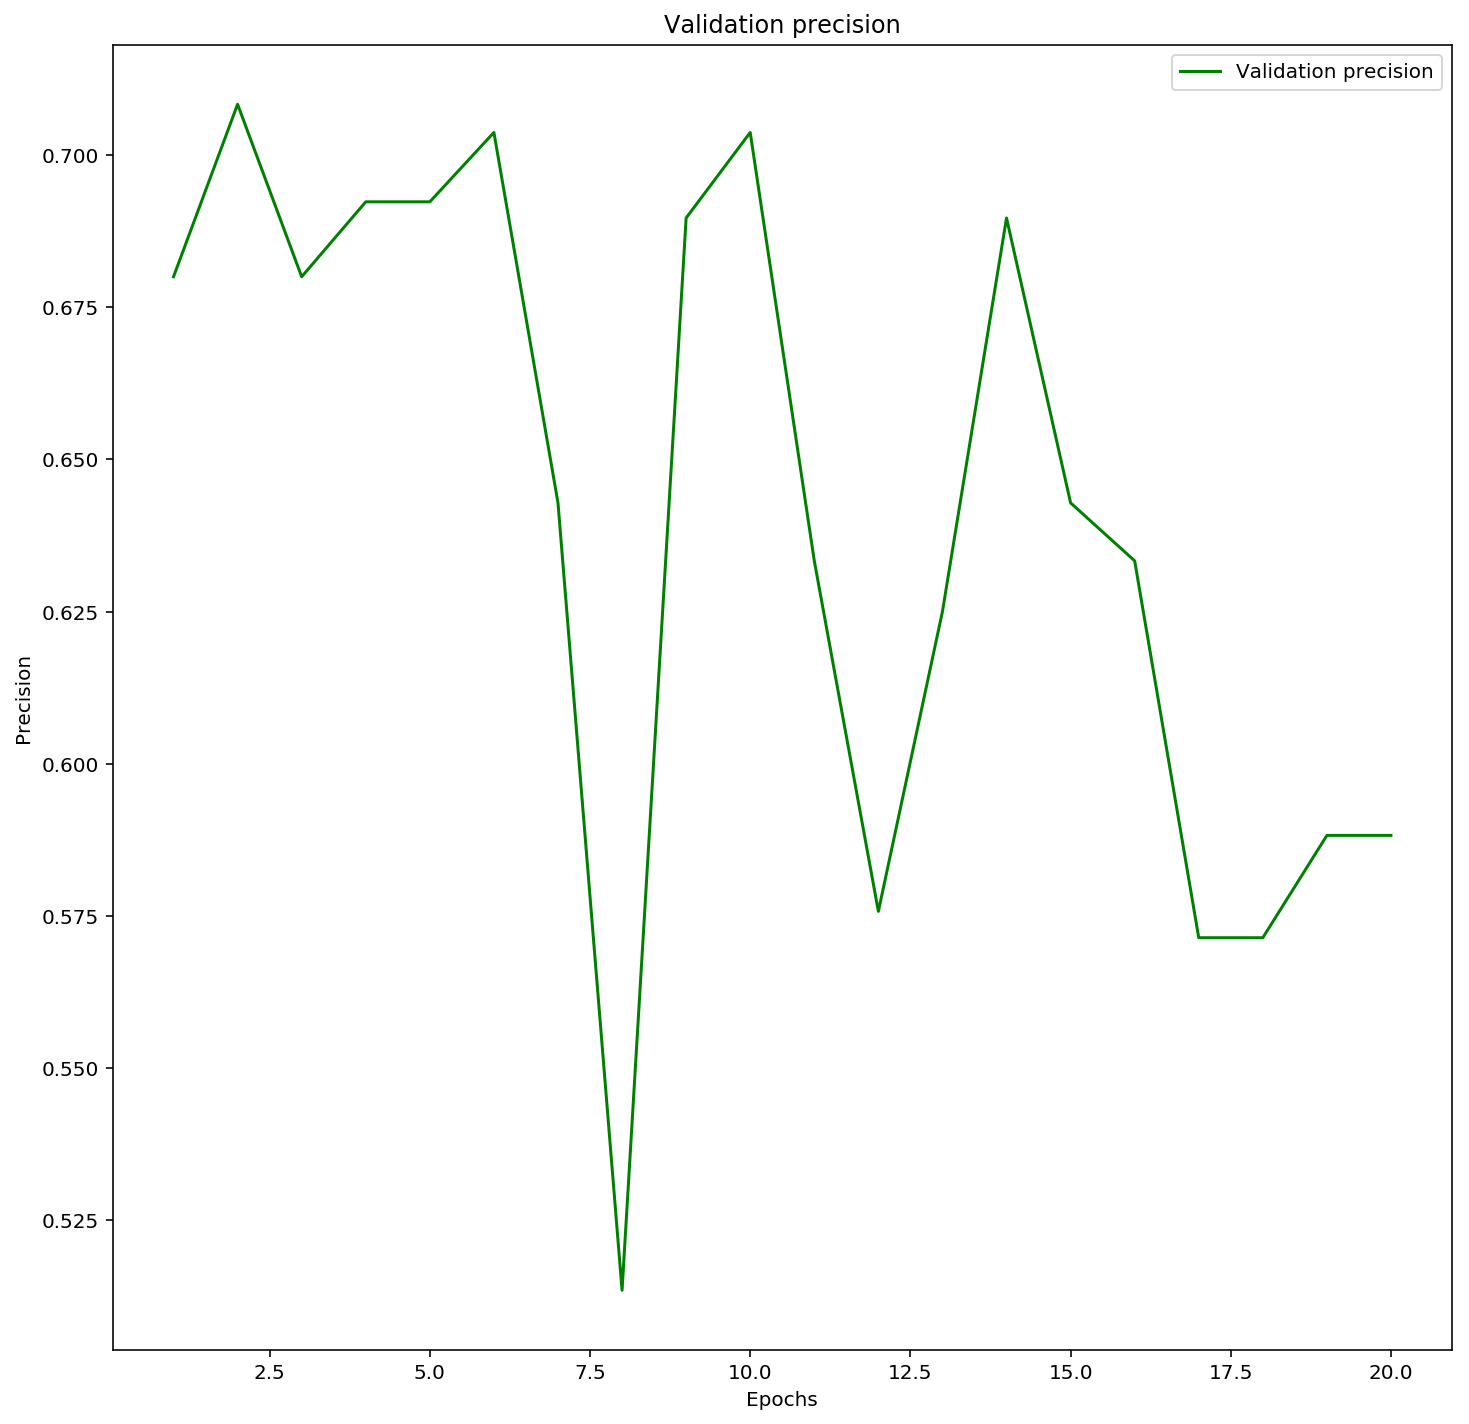

In [45]:
plt.figure(figsize=(12,12))
valPrecision = metricsHistory.valPrecisionHistory
plt.plot(epochs, valPrecision, 'g', label='Validation precision')
plt.title('Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

### Plot recall (for matching records)

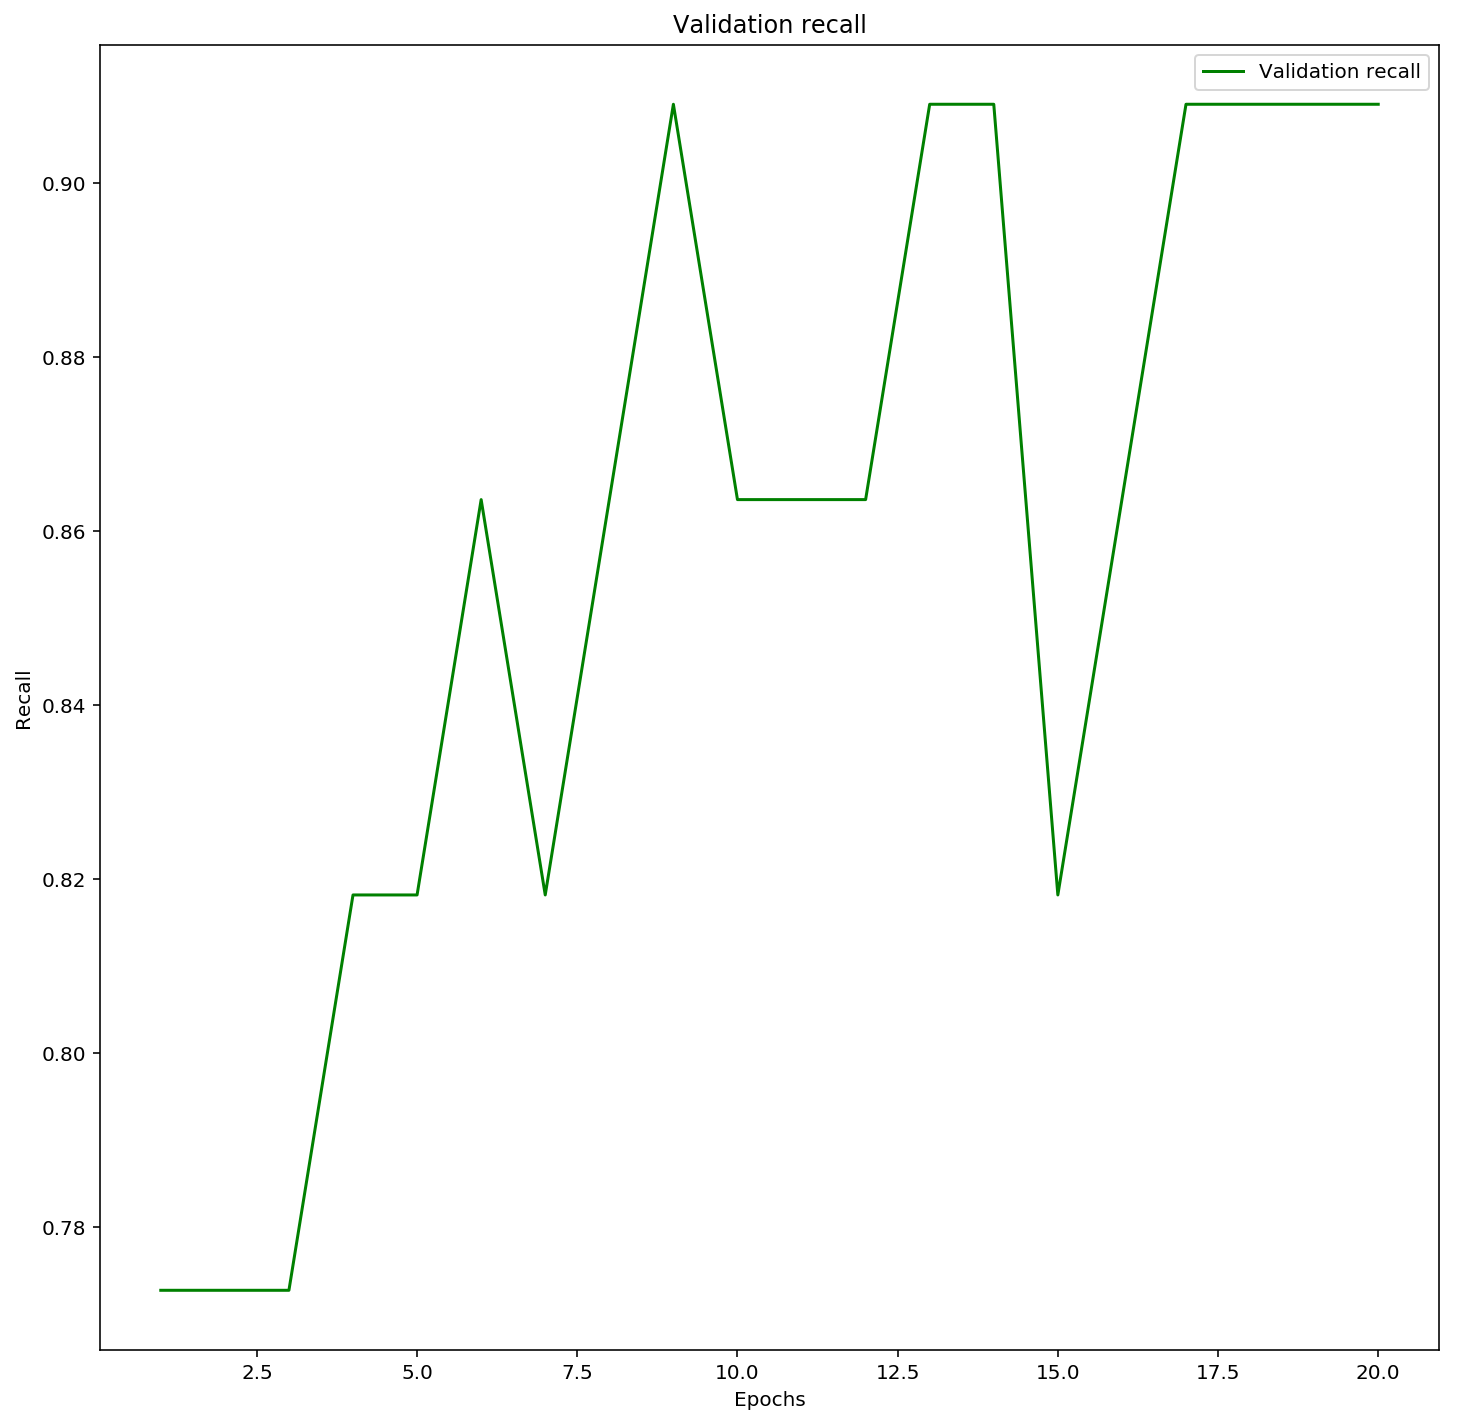

In [46]:
plt.figure(figsize=(12,12))
valRecall = metricsHistory.valRecallHistory
plt.plot(epochs, valRecall, 'g', label='Validation recall')
plt.title('Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

### Plot F-measure (for matching records)

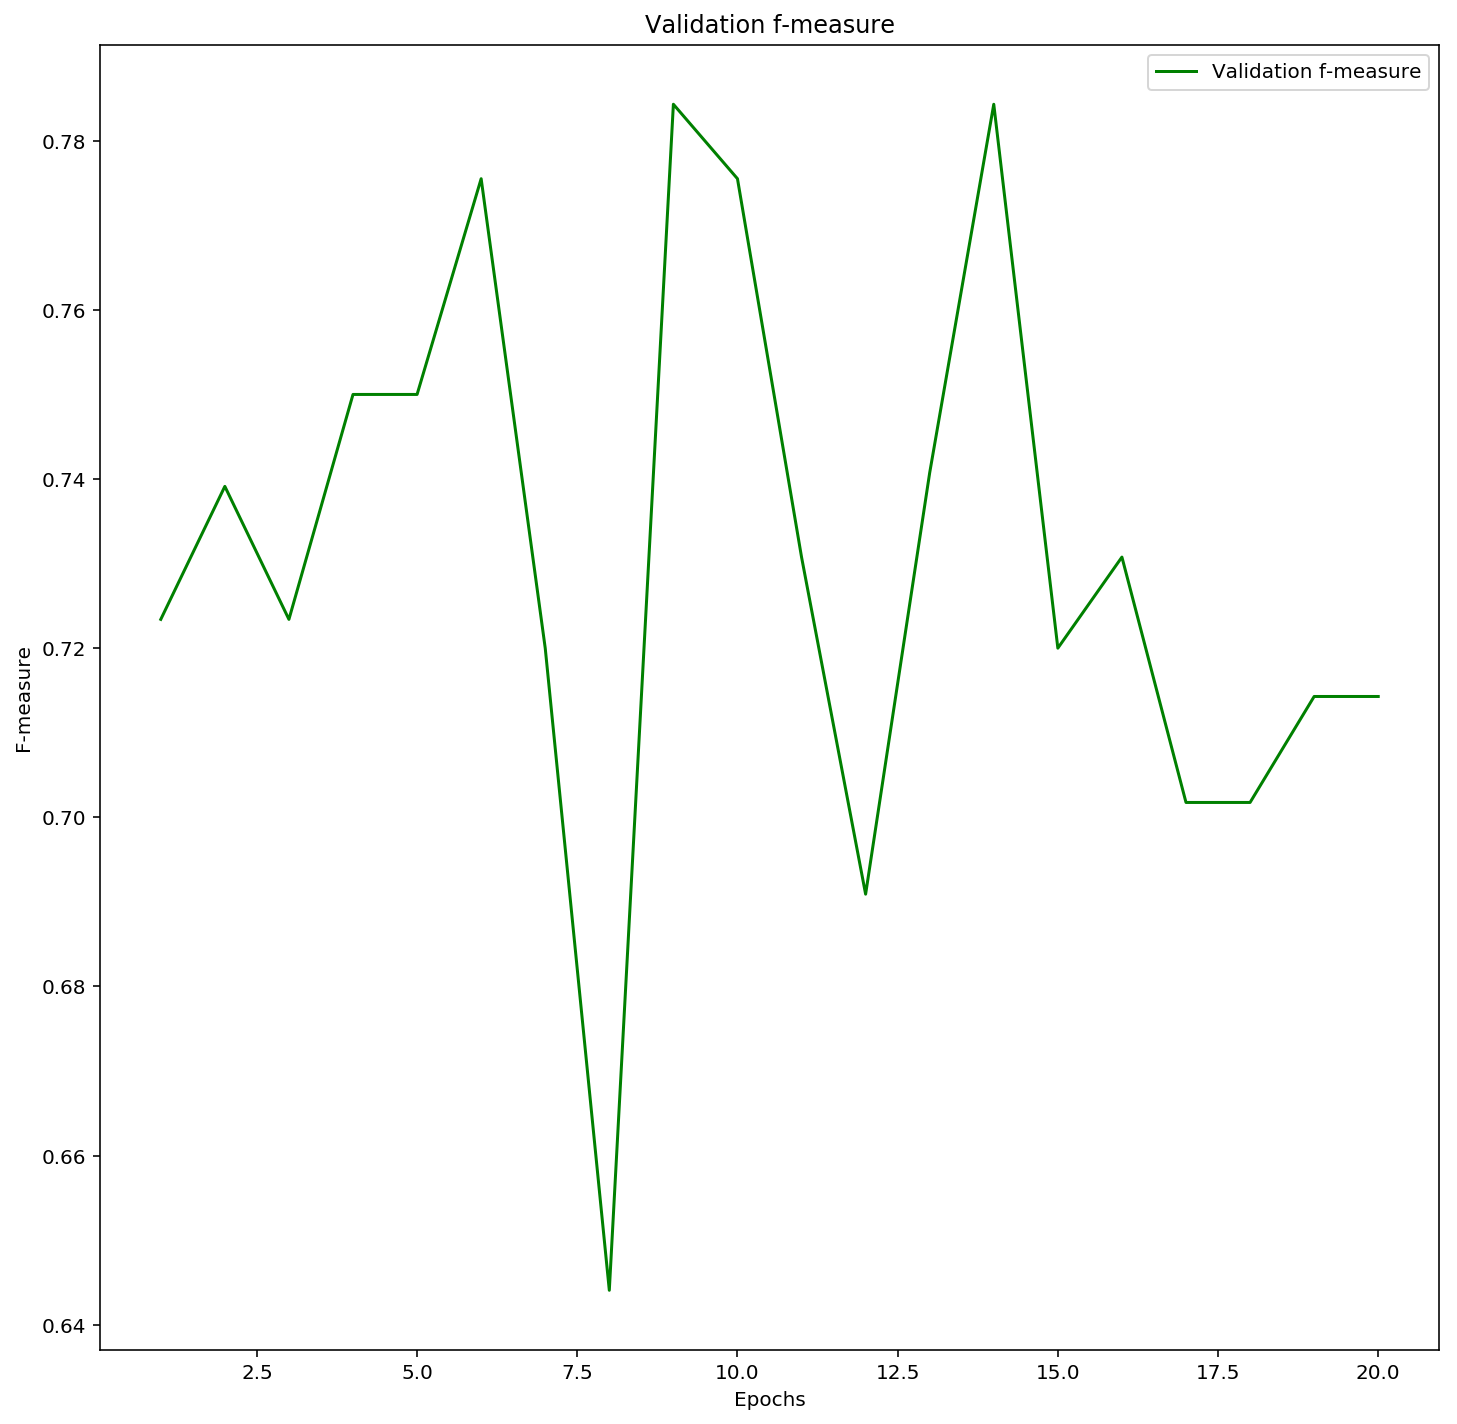

In [47]:
plt.figure(figsize=(12,12))
valFMeasure = metricsHistory.valFMeasureHistory
plt.plot(epochs, valFMeasure, 'g', label='Validation f-measure')
plt.title('Validation f-measure')
plt.xlabel('Epochs')
plt.ylabel('F-measure')
plt.legend()

### Predict labels on test data 

In [48]:
predictedLabels = model.predict(x=[leftTableTestData, rightTableTestData])
predictedBinaryLabels = predictedLabels.argmax(axis=1)
testBinaryLabels = testLabels.argmax(axis=1)

### Compute confusion matrix

[Text(0, 0.5, 'non matching'), Text(0, 1.5, 'matching')]

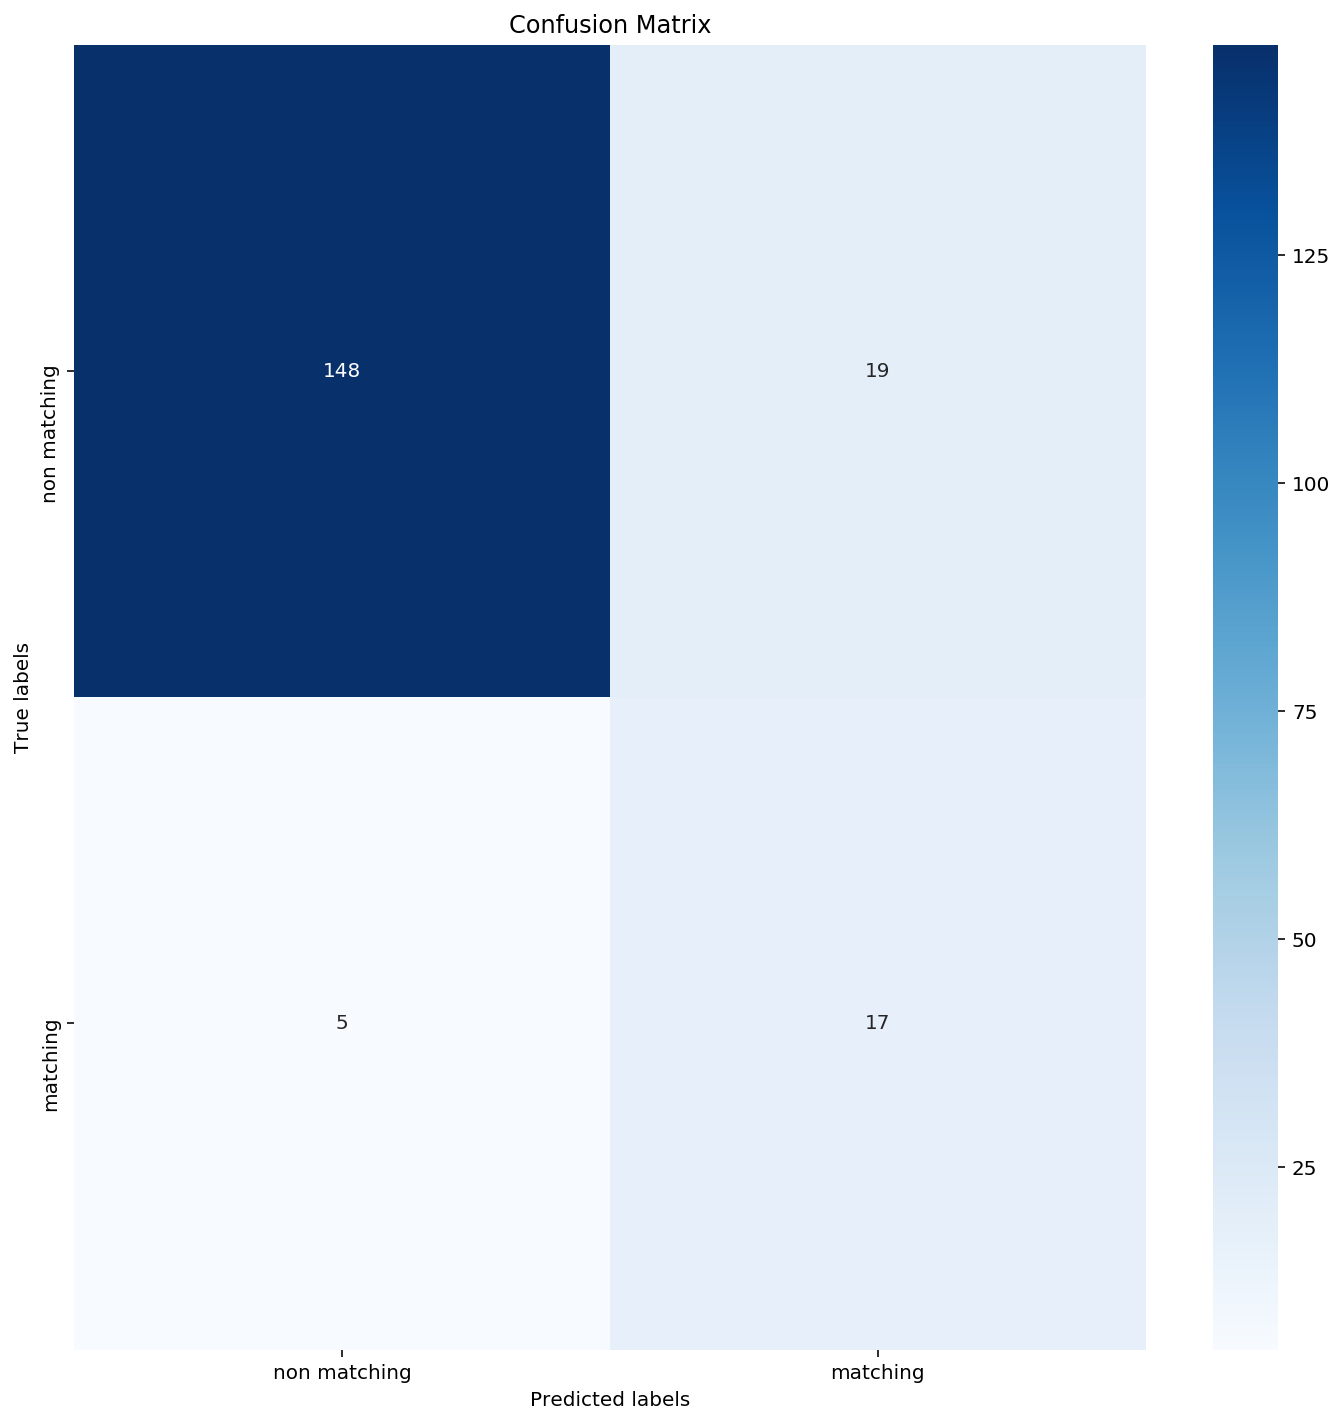

In [49]:
cm = confusion_matrix(testBinaryLabels, predictedBinaryLabels)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['non matching', 'matching'])
ax.yaxis.set_ticklabels(['non matching', 'matching'])

### Compute metrics

In [55]:
precisionValues, recallValues, fMeasureValues, supportValues = precision_recall_fscore_support(testBinaryLabels, predictedBinaryLabels)

NUM_LABELS = len(precisionValues)

row_format ="{:>15}" * 5
print(row_format.format('Label','Precision', 'Recall', 'F-measure', 'Support'))

for i in range(NUM_LABELS):
    fMeasure = fMeasureValues[i]
    
    if fMeasure is None:
        fMeasure = 0.0
        
    print(row_format.format(i, round(precisionValues[i], 2), round(recallValues[i], 2), round(fMeasureValues[i],2), round(supportValues[i],2)))

          Label      Precision         Recall      F-measure        Support
              0           0.97           0.89           0.92            167
              1           0.47           0.77           0.59             22
